### Set directories

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import re
from glob import glob
path = "./drive/MyDrive/SSSL/HRTF/IRC_*"
names = []
names += glob(path)
print(names[0])

splitnames = [os.path.split(name) for name in names]
print(len(splitnames))

p = re.compile('IRC_\d{4,4}')
print(p)

subjects = [int(name[4:8]) for base, name in splitnames 
                         if not (p.match(name[-8:]) is None)]
print(subjects)

./drive/MyDrive/SSSL/HRTF/IRC_1002
1
re.compile('IRC_\\d{4,4}')
[1002]


### load data from .mat files

In [3]:
from scipy.io import loadmat

k = 0
subject = subjects[k]

for k in range(len(names)):
    subject = subjects[k]
    # filename = os.path.join(names[k], 'IRC_' + str(subject))
    filename = os.path.join(names[k], 'COMPENSATED/MAT/HRIR/IRC_' + str(subject) + '_C_HRIR.mat')
#     print(filename)

### Create labels (azimuth, elevation)

dict_keys(['__header__', '__version__', '__globals__', 'r_eq_hrir_S', 'l_eq_hrir_S'])
[('elev_v', 'O'), ('azim_v', 'O'), ('type_s', 'O'), ('sampling_hz', 'O'), ('content_m', 'O')]
(187, 2)
(187, 2, 512)


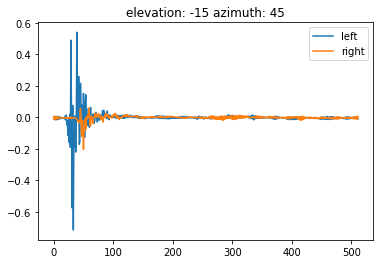

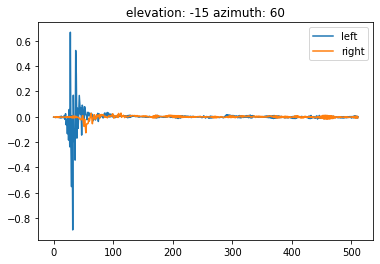

In [4]:
import numpy as np
import matplotlib.pyplot as plt 

m = loadmat(filename, struct_as_record=True)
print(m.keys())
print(m['l_eq_hrir_S'].dtype)

l, r = m['l_eq_hrir_S'], m['r_eq_hrir_S']
hrirSet_l = l['content_m'][0][0]
hrirSet_r = r['content_m'][0][0]
elev = l['elev_v'][0][0]
azim = l['azim_v'][0][0]

label = np.hstack((elev, azim))
print(label.shape)

# 0: left-ear 1: right-ear
hrirSet = np.vstack((np.reshape(hrirSet_l, (1,) + hrirSet_l.shape),
                          np.reshape(hrirSet_r, (1,) + hrirSet_r.shape)))
hrirSet = np.transpose(hrirSet, (1,0,2))
print(hrirSet.shape)

for i in range(51,53):
    plt.plot(hrirSet[i, 0])
    plt.plot(hrirSet[i, 1])
    plt.legend(['left','right'], loc='best')
    plt.title('elevation: '+str(label[i, 0])+' azimuth: '+str(label[i, 1]))
    
    plt.show()


### Convolve audio signals with left-ear and right-ear HRIR

Input:

- mono-track audio signal

Output:

- left-ear and right-ear time sequence pairs

In [58]:
import soundfile as sf
from random import gauss

basedir = os.getcwd()
print(basedir)
path = glob(os.path.join(basedir, "drive/MyDrive/SSSL/audio/*"))
print(path)

# left-ear and right-ear signal pairs
sigPairSet = []
audioIndex = -1
Nloc = 23 #hrirSet.shape[1]
lenHRIR = hrirSet.shape[-1]
valSNR = 10

for audioPath in path:
    audioIndex += 1
    data, sampleRate = sf.read(audioPath)
    print(data.shape)
    # audioSliceList = [range(sampleRate//1*i, sampleRate//1*(i+1)) for i in range(1, data.shape[-1]//(sampleRate//1))]
    # audioSliceList = [range(sampleRate*i, sampleRate*(i+1)) for i in range(180)]

    lenSlice =round(sampleRate * 1)
    lenAudio = data.shape[-1]
    audioSliceList = [range(lenSlice*i, lenSlice *(i+1)) for i in range(lenAudio//lenSlice)]

    sliceIndex = -1
    Nsamples = len(audioSliceList)
    print("Number of samples: ",Nsamples)
    lenTruncate = len(audioSliceList[0])
    
    lenAfterConv = lenHRIR+lenTruncate-1
    sigPair = np.zeros((Nsamples, Nloc, 2, lenAfterConv))
    print(sigPair.shape)

    for audioSlice in audioSliceList:
        sliceIndex += 1
        audio = data[audioSlice]
        lenAfterConv = lenHRIR+audio.size-1
        # print(len(audioSlice))
        # shape after convolution: 512 + audio length - 1

        # hrirSet is of shape (187, 2, 512)
        for locIndex in range(Nloc): 
            sigLeft = np.convolve(audio, hrirSet[locIndex, 0])
            sigRight = np.convolve(audio, hrirSet[locIndex, 1])

            sigLeft = sigLeft.reshape(1, sigLeft.shape[0])
            sigRight = sigRight.reshape(1, sigRight.shape[0])

            noiseLeftRMS = np.sqrt(np.mean(sigLeft**2)/np.power(10,valSNR/10))
            noiseRightRMS = np.sqrt(np.mean(sigRight**2)/np.power(10,valSNR/10))
            noiseLeft = np.random.normal(0, noiseLeftRMS, sigLeft.shape)
            noiseRight = np.random.normal(0, noiseRightRMS, sigRight.shape)

            # noiseIntensityLeft = sigLeft.max()*ampSNR
            # noiseIntensityRight = sigRight.max()*ampSNR

            # noiseLeft = [noiseIntensityLeft * gauss(0.0, 1.0) for _ in range(lenAfterConv)]
            # noiseLeft = np.array(noiseLeft).reshape(sigLeft.shape)
            # noiseRight = [noiseIntensityRight * gauss(0.0, 1.0) for _ in range(lenAfterConv)]
            # noiseRight = np.array(noiseRight).reshape(sigRight.shape)

            sigPair[sliceIndex, locIndex, 0] = sigLeft + noiseLeft
            sigPair[sliceIndex, locIndex, 1] = sigRight + noiseRight
    
    # sigPairSet.append(sigPair)

# # (slice no., left/right, 187 locations, signal length)
# sigPairSet = np.array(sigPairSet)
# tempShape = sigPairSet.shape

# sigPairSet = sigPairSet.reshape((tempShape[0],tempShape[2],tempShape[1],tempShape[3]))
# print(sigPairSet.shape)


/content
['/content/drive/MyDrive/SSSL/audio/music-fma-0001.wav']
(3488705,)
Number of samples:  218
(218, 23, 2, 16511)


In [76]:
valSNR=10
noiseLeftRMS = np.sqrt(np.mean(sigLeft**2)/np.power(10,valSNR/10))
noiseRightRMS = np.sqrt(np.mean(sigRight**2)/np.power(10,valSNR/10))
noiseLeft = np.random.normal(0, noiseLeftRMS, sigLeft.shape)
noiseRight = np.random.normal(0, noiseRightRMS, sigRight.shape)

print(noiseLeftRMS)
print(np.max(noiseLeft[0]))
print(sigLeft.max())

print(noiseRightRMS)
print(noiseRight.max())
print(sigRight.max())

2.1342124276381547e-06
9.49533707447494e-06
2.664645485730923e-05
4.416033918463125e-06
1.761572417929297e-05
5.530496168627224e-05


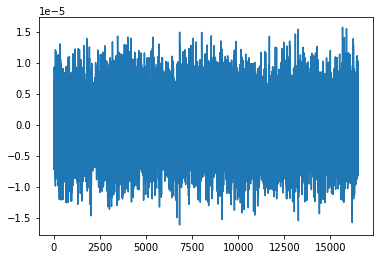

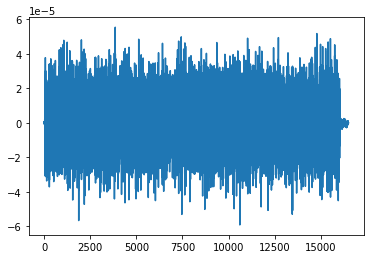

In [63]:
# visualise left-ear and right-ear signal pairs and their spectrogram
from scipy import signal
import random

plt.plot(noiseRight[0])
# plt.title('Time sequence pairs for location '+str(randomLoc))
# plt.legend(['left','right'])
plt.show()
plt.plot(sigRight[0])
plt.show()

# fs = sampleRate
# print(fs)

# f, t, Zxx = signal.stft(sigPair[randomExample, randomLoc, 0], fs, nperseg=1023)
# print(Zxx.shape)

# plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
# plt.title('STFT Magnitude (L/R) for location '+str(randomLoc))
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.show()

In [7]:
print(sigPair.shape)
print(sigLeft.shape)
print(audio.shape)

(218, 23, 2, 16511)
(1, 16511)
(16000,)


### Windowed FFT

Input:

- left-ear and right-ear time sequences

Output:

- left-ear and right-ear time-varying spectra



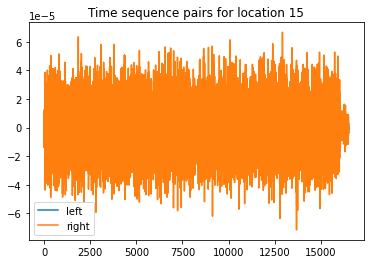

16000
(512, 34)


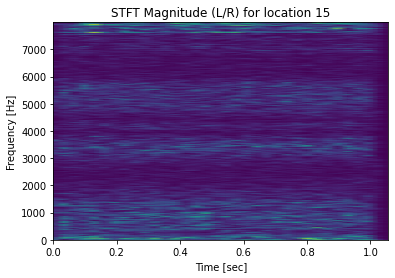

In [77]:
# visualise left-ear and right-ear signal pairs and their spectrogram
from scipy import signal
import random

randomExample = 0
randomLoc = random.randint(0, Nloc-1)
plt.plot(sigPair[randomExample, randomLoc, 0])
plt.plot(sigPair[randomExample, randomLoc, 1])
plt.title('Time sequence pairs for location '+str(randomLoc))
plt.legend(['left','right'])
plt.show()

fs = sampleRate
print(fs)

f, t, Zxx = signal.stft(sigPair[randomExample, randomLoc, 0], fs, nperseg=1023)
print(Zxx.shape)

plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude (L/R) for location '+str(randomLoc))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

### Feature extraction

- IPD cues (similar as ITD (ambiguous at high frequencies))

  arg(S_l/S_r)
  
  
- Spectral cues (essentially tells about ILD cues)

  do STFT and then convert it to magnitude and phase

In [78]:
def cartesian2euler(val):
    x = val.real
    y = val.imag
    
    r = np.sqrt(x**2+y**2)

    theta = np.arctan(
        np.divide(y, x, where=x!=0)
    )
    # if x != 0:
    #     theta = np.arctan(y/x)
    # else:
    #     theta = np.pi/2
        
    return normalise(r), (theta)

def calIPD(seqL, seqR):
    temp = np.divide(seqL, seqR, out=np.zeros_like(seqL), where=seqR!=0)
    ipd = np.arctan(np.divide(np.imag(temp), np.real(temp), out=np.zeros_like(np.real(temp)), where=np.real(temp)!=0))
    return ipd

def normalise(seq):
    return seq/np.linalg.norm(seq)

temp = np.array([[1, 2, 3],[1,2,3]])
print(normalise(temp))

[[0.18898224 0.37796447 0.56694671]
 [0.18898224 0.37796447 0.56694671]]


In [10]:
# calculate spectral and IPD cues
spectralCues = np.zeros(sigPair.shape[:-2] + (Zxx.shape[1], Zxx.shape[0]) + (4,), dtype='float')
ipdCues = np.zeros(sigPair.shape[:-2] + (Zxx.shape[1], Zxx.shape[0]), dtype='float')
print("IPD shape", ipdCues.shape)
print(sigPair.shape)

for i in range(Nsamples):
    if i%100 == 1:
        print("Sample ",i)
    for locIndex in range(Nloc):
        f_l, t_l, Zxx_l = signal.stft(sigPair[i, locIndex, 0], fs, nperseg=1023)
        f_r, t_r, Zxx_r = signal.stft(sigPair[i, locIndex, 1], fs, nperseg=1023)
#         print(Zxx_l.shape)
        
        ipdCues[i, locIndex] = normalise(np.transpose(calIPD(Zxx_l, Zxx_r), (1, 0)))
        
        r_l, theta_l = cartesian2euler(Zxx_l)
        r_r, theta_r = cartesian2euler(Zxx_r)
        # temp = np.array([r_l, theta_l, r_r, theta_r])
        # print(temp.shape)
        spectralCues[i, locIndex] = np.transpose(np.array([r_l, theta_l, r_r, theta_r]), (2, 1 ,0))
        
        # for timeIndex in range(Zxx_l.shape[1]):
        #     for freqIndex in range(Zxx_l.shape[0]):
        #         r_l, theta_l = cartesian2euler(Zxx_l[freqIndex][timeIndex])
        #         r_r, theta_r = cartesian2euler(Zxx_r[freqIndex][timeIndex])

        #         spectralCues[i, locIndex, timeIndex, freqIndex] = np.array([r_l, theta_l, r_r, theta_r])
                # print(spectralCues[i, locIndex, timeIndex, freqIndex].shape)
                
        
ipdCues = np.transpose(ipdCues, (1, 0, 2, 3))
spectralCues = np.transpose(spectralCues, (1, 0, 2, 3, 4))


IPD shape (218, 23, 34, 512)
(218, 23, 2, 16511)
Sample  1
Sample  101
Sample  201


In [11]:
print("Size of feature matrices:")
print(ipdCues.shape)
print(spectralCues.shape)


Size of feature matrices:
(23, 218, 34, 512)
(23, 218, 34, 512, 4)


### Data visualisation

In [12]:
# IPD visualisation

# plt.plot(ipdCues[0,0,100:105,:])

# plt.pcolormesh(t_l, f_l, np.abs(ipdCues[random.randint(0,186), 0]), shading='gouraud')
# plt.title('IPD cues')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.show() 

In [13]:
# plt.pcolormesh(t, f, spectralCues[random.randint(0,186), 0, :,:,3], shading='gouraud')
# plt.title('Spectral cues (left-ear)')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.colorbar()
# plt.show()


### Tensorisation

In [79]:
import numpy as np
import random
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils import class_weight
from torch.autograd import Variable
import torch.nn.functional as F

ipd = torch.from_numpy(ipdCues.astype(np.float32))
slMag = torch.from_numpy(spectralCues[:,:,:,:,0].astype(np.float32))
slPhase = torch.from_numpy(spectralCues[:,:,:,:,1].astype(np.float32))
srMag = torch.from_numpy(spectralCues[:,:,:,:,2].astype(np.float32))
srPhase = torch.from_numpy(spectralCues[:,:,:,:,3].astype(np.float32))
print(ipd.shape)

labels = np.zeros((ipd.shape[0], ipd.shape[1], 1)).astype(np.long)
print("labels shape",labels.shape)
for i in range(ipd.shape[0]):
    for j in range(ipd.shape[1]):
        labels[i,j] = i
print("shape: ",slMag.shape)
print(slMag[1,2,0,0:10])

labels = torch.from_numpy(labels)
labels_ = labels.reshape(labels.shape[0]*labels.shape[1], 1)

ipd_ = ipd.reshape(ipd.shape[0]*ipd.shape[1], ipd.shape[2], ipd.shape[3])
slMag_ = slMag.reshape(slMag.shape[0]*slMag.shape[1], slMag.shape[2], slMag.shape[3])
slPhase_ = slPhase.reshape(slPhase.shape[0]*slPhase.shape[1], slPhase.shape[2], slPhase.shape[3])
srMag_ = srMag.reshape(srMag.shape[0]*srMag.shape[1], srMag.shape[2], srMag.shape[3])
srPhase_ = srPhase.reshape(srPhase.shape[0]*srPhase.shape[1], srPhase.shape[2], srPhase.shape[3])
print(slMag_.shape)
print(slMag_[5,0,0:10])

torch.Size([23, 218, 34, 512])
labels shape (23, 218, 1)
shape:  torch.Size([23, 218, 34, 512])
tensor([2.5202e-03, 2.5901e-03, 2.2190e-03, 1.1432e-03, 1.0688e-04, 4.8700e-04,
        3.2725e-05, 1.1308e-03, 2.2398e-03, 2.5585e-03])
torch.Size([5014, 34, 512])
tensor([0.0027, 0.0030, 0.0053, 0.0059, 0.0034, 0.0042, 0.0060, 0.0053, 0.0046,
        0.0035])


In [15]:
dataSet = torch.stack([ipd_, slMag_, slPhase_, srMag_, srPhase_]).permute(1, 2, 3, 0)
print(dataSet.shape)
print(labels_.shape)
train_data = TensorDataset(dataSet, labels_)

Ntrain = round(0.6*dataSet.shape[0])
Nvalid = round(0.2*dataSet.shape[0])
Ntest = round(0.2*dataSet.shape[0])
print("Dataset separation: ",Ntrain, Nvalid, Ntest)

train, valid, test = torch.utils.data.random_split(train_data, [Ntrain, Nvalid, Ntest], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(dataset=train, batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset=valid, batch_size=32, shuffle=True, num_workers=0)


torch.Size([5014, 34, 512, 5])
torch.Size([5014, 1])
Dataset separation:  3008 1003 1003


### Model 1

In [80]:
class SelfAttention(nn.Module):
    def __init__(self, freqSize, heads):
        super(SelfAttention, self).__init__()
        self.freqSize = freqSize
        self.heads = heads
        self.head_dim = freqSize // heads

        # assert debug
        assert (
            self.head_dim * heads == freqSize
        ), "Embedding size needs to be divisible by heads"

        # obtain Q K V matrices by linear transformation
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, freqSize)

    def forward(self, value, key, query):
        # Get number of training examples
        N = query.shape[0]

        value_time, value_freq = value.shape[1], value.shape[2]
        key_time, key_freq = key.shape[1], key.shape[2]
        query_time, query_freq = query.shape[1], query.shape[2]

        # Split the embedding into self.heads different pieces
        value = value.reshape(N, value_time, self.heads, self.head_dim)
        key = key.reshape(N, key_time, self.heads, self.head_dim)
        query = query.reshape(N, query_time, self.heads, self.head_dim)

        values = self.values(value)  # (N, value_len, heads, head_dim)
        keys = self.keys(key)  # (N, key_len, heads, head_dim)
        queries = self.queries(query)  # (N, query_len, heads, heads_dim)

        # Einsum does matrix mult. for query*keys for each training example
        # with every other training example, don't be confused by einsum
        # it's just how I like doing matrix multiplication & bmm

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim),
        # keys shape: (N, key_len, heads, heads_dim)
        # energy: (N, heads, query_len, key_len)

        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for
        # better stability
        attention = torch.softmax(energy / (self.freqSize ** (1 / 2)), dim=3)
        # attention shape: (N, heads, query_len, key_len)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_time, self.heads * self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # out after matrix multiply: (N, query_len, heads, head_dim), then
        # we reshape and flatten the last two dimensions.

        out = self.fc_out(out)
        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)
        return out


class Attention(nn.Module):
    def __init__(self, embedSize, locSize):
        super(Attention, self).__init__()
        self.embedSize = embedSize

        # obtain Q K V matrices by linear transformation
        self.values = nn.Linear(embedSize, embedSize, bias=False)
        self.keys = nn.Linear(embedSize, embedSize, bias=False)
        self.queries = nn.Linear(embedSize, embedSize, bias=False)
        self.fc_out = nn.Linear(embedSize, locSize)

    def forward(self, value, key, query):
        # Get number of training examples
        N = query.shape[0]

        value_time, value_freq = value.shape[1], value.shape[2]
        key_time, key_freq = key.shape[1], key.shape[2]
        query_time, query_freq = query.shape[1], query.shape[2]

        values = self.values(value)  # (N, value_len, heads, head_dim)
        keys = self.keys(key)  # (N, key_len, heads, head_dim)
        queries = self.queries(query)  # (N, query_len, heads, heads_dim)

        # Einsum does matrix mult. for query*keys for each training example
        # with every other training example, don't be confused by einsum
        # it's just how I like doing matrix multiplication & bmm

        energy = torch.einsum("ntqe,ntke->neqk", [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim),
        # keys shape: (N, key_len, heads, heads_dim)
        # energy: (N, heads, query_len, key_len)

        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for
        # better stability
        attention = torch.softmax(energy / (self.embedSize ** (1 / 2)), dim=3)

        # attention shape: (N, heads, query_len, key_len)

        out = torch.einsum("neqk,ntve->ntqe", [attention, values]).reshape(
            N, query_time, query_freq, self.embedSize
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # out after matrix multiply: (N, query_len, heads, head_dim), then
        # we reshape and flatten the last two dimensions.

        out = self.fc_out(out)
        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)
        return out

class TransformerBlock(nn.Module):
    def __init__(self, freqSize, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(freqSize, heads)
        self.norm1 = nn.LayerNorm(freqSize)
        self.norm2 = nn.LayerNorm(freqSize)

        self.feed_forward = nn.Sequential(
            nn.Linear(freqSize, forward_expansion * freqSize),
            nn.ReLU(),
            nn.Linear(forward_expansion * freqSize, freqSize),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query):
        attention = self.attention(value, key, query)

        # Add skip connection, run through normalization and finally dropout
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

class Encoder(nn.Module):
    def __init__(
        self,
        freqSize, # frequency bins
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
    ):

        super(Encoder, self).__init__()
        self.freqSize = freqSize
        self.device = device

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    freqSize,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        timeSize, freqSize = x.shape[-2], x.shape[-1]
        # positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(x)

        # In the Encoder the query, key, value are all the same, it's in the
        # decoder this will change. This might look a bit odd in this case.
        for layer in self.layers:
            out = layer(out, out, out)

        return out

class SSSL(nn.Module):
    def __init__(
    self,
    locSize,
    timeSize, # time windows
    freqSize, # frequency bins
    num_layers,
    heads,
    device,
    forward_expansion,
    dropout,
    ):
        super(SSSL, self).__init__()
        self.encoder = Encoder(           
            freqSize, # frequency bins
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
        )
        self.attention = Attention(5, locSize)
        self.fcFreq = nn.Linear(freqSize, 1)
        self.fcTime = nn.Linear(timeSize, 1)
        # self.softmaxLayer = nn.Softmax(dim = -1)
    def forward(self, ipd, slMag, slPhase, srMag, srPhase):
        enc_ipd = self.encoder(ipd)
        enc_slMag = self.encoder(slMag)
        enc_slPhase = self.encoder(slPhase)
        enc_srMag = self.encoder(srMag)
        enc_srPhase = self.encoder(srPhase)
        enc = torch.stack([enc_ipd, enc_slMag, enc_slPhase, enc_srMag, enc_srPhase])
        enc = enc.permute(1,2,3,0)
        # encCat = torch.cat((enc_ipd, enc_slMag, enc_slPhase, enc_srMag, enc_srPhase), -1)
        # print(enc.shape)

        attOut = self.attention(enc, enc, enc)

        # out = self.fcFreq(attOut.permute(0,1,3,2))
        # out = out.squeeze(-1)

        out = torch.mean(attOut, -2)
        out = out.squeeze(-1)
        
        # out = self.fcTime(out.permute(0, 2, 1))
        # out = out.squeeze(-1)

        out = torch.mean(out, -2)
        out = out.squeeze(-2)


        # out = self.softmaxLayer(out)
        return out

Nfreq = ipd_.shape[2]
print(Nfreq)
Ntime = ipd_.shape[1]
print(Ntime)
# Nloc = 187
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
numLayers = 6
model = SSSL(Nloc, Ntime, Nfreq, numLayers, 8, device, 4, 0).to(device)
testOut = model(ipd_[0:2].to(device),ipd_[0:2].to(device),ipd_[0:2].to(device),ipd_[0:2].to(device),ipd_[0:2].to(device))
print(testOut.shape)

512
34
torch.Size([2, 23])


In [17]:
torch.cuda.memory_summary(device=device, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  150662 KB |  166749 KB |  193411 KB |   42749 KB |\n|       from large pool |   69632 KB |   83000 KB |   83000 KB |   13368 KB |\n|       from small pool |   81030 KB |   83749 KB |  110411 KB |   29381 KB |\n|---------------------------------------------------------------------------|\n| Active memory         |  150662 KB |  166749 KB |  193411 KB |   42749 KB |\n|       from large pool |   69632 KB |   83000 KB |

### Network training

In [81]:
import gc

gc.collect()
torch.cuda.empty_cache()

num_epochs = 10000
learning_rate = 1e-4
# batch_size = 32
early_epoch = 100
new_early_epoch = 0
new_val_loss = 0.0

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=20, verbose=True)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    print("\nEpoch %d" % (epoch + 1))
    model.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0

    for i, data in enumerate(train_loader, 0):
        length = len(train_loader)
        inputs, labels = data
        inputs, labels = Variable(inputs).to(device), Variable(labels.long()).to(device)
        # print(inputs.shape)
        # print(labels.shape)

        
        ipd = inputs[:,:,:,0]
        # print(ipd.shape)
        slMag = inputs[:,:,:,1]
        slPhase = inputs[:,:,:,2]
        srMag = inputs[:,:,:,3]
        srPhase = inputs[:,:,:,4]
        
        # outputs = model(ipd)
        outputs = model(ipd,slMag,slPhase,srMag,srPhase)

        # print("Ouput shape: ", outputs.shape)
        # print("Label shape: ", labels.shape)
        loss = criterion(outputs, labels.squeeze(1))
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()

        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.squeeze(1).data).sum().item()
    print("correct:",correct)
    print("total",total)
    print('[epoch:%d] Loss: %.04f | Acc: %.4f%% '
        % (epoch + 1, sum_loss / (i + 1), 100.0 * correct / total))
    

    val_loss = 0.0
    val_correct = 0.0
    val_total = 0.0

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(valid_loader, 0):
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device), Variable(labels.long()).to(device)

            ipd = inputs[:,:,:,0]
            slMag = inputs[:,:,:,1]
            slPhase = inputs[:,:,:,2]
            srMag = inputs[:,:,:,3]
            srPhase = inputs[:,:,:,4]
            
            outputs = model(ipd, slMag, slPhase, srMag, srPhase)
            val_loss = criterion(outputs, labels.squeeze(1))
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels.squeeze(1).data).sum().item()
        # scheduler.step(val_loss)

    print('Val_Loss: %.04f | Val_Acc: %.4f%% '
        % (val_loss, 100.0 * val_correct / val_total))

    if (100.0 * val_correct / val_total <= new_val_loss):
        new_early_epoch += 1
    else:
        new_val_loss = 100.0 * val_correct / val_total
        new_early_epoch = 0
    if (new_early_epoch >= early_epoch):
        break


Epoch 1
correct: 138.0
total 3008.0
[epoch:1] Loss: 3.1549 | Acc: 4.5878% 
Val_Loss: 3.0856 | Val_Acc: 3.6889% 

Epoch 2
correct: 131.0
total 3008.0
[epoch:2] Loss: 3.1549 | Acc: 4.3551% 
Val_Loss: 3.2312 | Val_Acc: 4.3868% 

Epoch 3
correct: 143.0
total 3008.0
[epoch:3] Loss: 3.1542 | Acc: 4.7540% 
Val_Loss: 3.1958 | Val_Acc: 4.3868% 

Epoch 4
correct: 130.0
total 3008.0
[epoch:4] Loss: 3.1533 | Acc: 4.3218% 
Val_Loss: 3.1143 | Val_Acc: 4.3868% 

Epoch 5
correct: 136.0
total 3008.0
[epoch:5] Loss: 3.1530 | Acc: 4.5213% 
Val_Loss: 3.0800 | Val_Acc: 4.3868% 

Epoch 6
correct: 137.0
total 3008.0
[epoch:6] Loss: 3.1486 | Acc: 4.5545% 
Val_Loss: 3.1339 | Val_Acc: 6.7797% 

Epoch 7
correct: 241.0
total 3008.0
[epoch:7] Loss: 3.1289 | Acc: 8.0120% 
Val_Loss: 3.1942 | Val_Acc: 6.0818% 

Epoch 8
correct: 260.0
total 3008.0
[epoch:8] Loss: 3.0924 | Acc: 8.6436% 
Val_Loss: 2.8936 | Val_Acc: 8.2752% 

Epoch 9
correct: 293.0
total 3008.0
[epoch:9] Loss: 3.0512 | Acc: 9.7407% 
Val_Loss: 2.9011 | V

KeyboardInterrupt: ignored

### Model 2

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, freqSize, heads):
        super(SelfAttention, self).__init__()
        self.freqSize = freqSize
        self.heads = heads
        self.head_dim = freqSize // heads

        # assert debug
        assert (
            self.head_dim * heads == freqSize
        ), "Embedding size needs to be divisible by heads"

        # obtain Q K V matrices by linear transformation
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, freqSize)

    def forward(self, value, key, query):
        # Get number of training examples
        N = query.shape[0]
        
        value_time, value_freq = value.shape[1], value.shape[2]
        key_time, key_freq = key.shape[1], key.shape[2]
        query_time, query_freq = query.shape[1], query.shape[2]

        # Split the embedding into self.heads different pieces
        value = value.reshape(N, value_time, self.heads, self.head_dim)
        key = key.reshape(N, key_time, self.heads, self.head_dim)
        query = query.reshape(N, query_time, self.heads, self.head_dim)

        values = self.values(value)  # (N, value_len, heads, head_dim)
        keys = self.keys(key)  # (N, key_len, heads, head_dim)
        queries = self.queries(query)  # (N, query_len, heads, heads_dim)

        # Einsum does matrix mult. for query*keys for each training example
        # with every other training example, don't be confused by einsum
        # it's just how I like doing matrix multiplication & bmm

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim),
        # keys shape: (N, key_len, heads, heads_dim)
        # energy: (N, heads, query_len, key_len)

        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for
        # better stability
        attention = torch.softmax(energy / (self.freqSize ** (1 / 2)), dim=3)
        # attention shape: (N, heads, query_len, key_len)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_time, self.heads * self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # out after matrix multiply: (N, query_len, heads, head_dim), then
        # we reshape and flatten the last two dimensions.

        out = self.fc_out(out)
        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)
        return out


'''class Attention(nn.Module):
    def __init__(self, embedSize, locSize):
        super(Attention, self).__init__()
        self.embedSize = embedSize

        # obtain Q K V matrices by linear transformation
        self.values = nn.Linear(embedSize, embedSize, bias=False)
        self.keys = nn.Linear(embedSize, embedSize, bias=False)
        self.queries = nn.Linear(embedSize, embedSize, bias=False)
        self.fc_out = nn.Linear(embedSize, locSize)

    def forward(self, value, key, query):
        # Get number of training examples
        N = query.shape[0]

        value_time, value_freq = value.shape[1], value.shape[2]
        key_time, key_freq = key.shape[1], key.shape[2]
        query_time, query_freq = query.shape[1], query.shape[2]

        values = self.values(value)  # (N, value_len, heads, head_dim)
        keys = self.keys(key)  # (N, key_len, heads, head_dim)
        queries = self.queries(query)  # (N, query_len, heads, heads_dim)

        # Einsum does matrix mult. for query*keys for each training example
        # with every other training example, don't be confused by einsum
        # it's just how I like doing matrix multiplication & bmm

        energy = torch.einsum("ntqe,ntke->neqk", [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim),
        # keys shape: (N, key_len, heads, heads_dim)
        # energy: (N, heads, query_len, key_len)

        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for
        # better stability
        attention = torch.softmax(energy / (self.embedSize ** (1 / 2)), dim=3)

        # attention shape: (N, heads, query_len, key_len)

        out = torch.einsum("neqk,ntve->ntqe", [attention, values]).reshape(
            N, query_time, query_freq, self.embedSize
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # out after matrix multiply: (N, query_len, heads, head_dim), then
        # we reshape and flatten the last two dimensions.

        out = self.fc_out(out)
        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)
        return out'''

class TransformerBlock(nn.Module):
    def __init__(self, freqSize, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(freqSize, heads)
        self.norm1 = nn.LayerNorm(freqSize)
        self.norm2 = nn.LayerNorm(freqSize)

        self.feed_forward = nn.Sequential(
            nn.Linear(freqSize, forward_expansion * freqSize),
            nn.ReLU(),
            nn.Linear(forward_expansion * freqSize, freqSize),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query):
        attention = self.attention(value, key, query)

        # Add skip connection, run through normalization and finally dropout
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

class Encoder(nn.Module):
    def __init__(
        self,
        freqSize, # frequency bins
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
    ):

        super(Encoder, self).__init__()
        self.freqSize = freqSize
        self.device = device

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    freqSize,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        timeSize, freqSize = x.shape[-2], x.shape[-1]
        # positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(x)

        # In the Encoder the query, key, value are all the same, it's in the
        # decoder this will change. This might look a bit odd in this case.
        for layer in self.layers:
            out = layer(out, out, out)

        return out

class SSSL(nn.Module):
    def __init__(
    self,
    locSize,
    timeSize, # time windows
    freqSize, # frequency bins
    num_layers,
    heads,
    device,
    forward_expansion,
    dropout,
    isDebug
    ):
        super(SSSL, self).__init__()
        self.encoder = Encoder(           
            freqSize, # frequency bins
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
        )
        self.isDebug = isDebug
        # self.attention = Attention(5, locSize)
        self.fcFreq = nn.Linear(freqSize, locSize)
        self.fcTime = nn.Linear(timeSize, 1)
        # self.softmaxLayer = nn.Softmax(dim = -1)
    def forward(self, ipd):
        enc_ipd = self.encoder(ipd)
        if self.isDebug == True:
            print("enc_ipd shape: ",enc_ipd.shape)
        # enc_slMag = self.encoder(slMag)
        # enc_slPhase = self.encoder(slPhase)
        # enc_srMag = self.encoder(srMag)
        # enc_srPhase = self.encoder(srPhase)
        # enc = torch.stack([enc_ipd, enc_slMag, enc_slPhase, enc_srMag, enc_srPhase])
        # enc = enc.permute(1,2,3,0)
        # encCat = torch.cat((enc_ipd, enc_slMag, enc_slPhase, enc_srMag, enc_srPhase), -1)
        # print(enc.shape)

        # attOut = self.attention(enc, enc, enc)
        # print(enc_ipd.shape)
        out = self.fcFreq(enc_ipd)
        if self.isDebug == True:
            print("FC freq shape: ",out.shape)
        # out = out.squeeze(-1)

        # out = torch.mean(attOut, -2)
        # out = out.squeeze(-1)
        # print(out.shape)
        out = self.fcTime(out.permute(0,2,1))
        out = out.squeeze(-1)
        if self.isDebug == True:
            print("FC time shape: ",out.shape)

        # out = torch.mean(out, -2)
        # out = out.squeeze(-2)


        # out = self.softmaxLayer(out)
        return out

Nfreq = ipd_.shape[2]
print(Nfreq)
Ntime = ipd_.shape[1]
print(Ntime)
# Nloc = 187
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
numLayers = 6
model = SSSL(Nloc, Ntime, Nfreq, numLayers, 8, device, 4, 0, 0).to(device)


testOut = model(ipd_[0:32].to(device))